In [2]:
import os
import pandas as pd
import requests, json
%run APIkeys.py

API keys loaded


In [4]:
GE_WF_UPCSs = ["16000124790", "16000122543", "16000125063", "16000123991", "16000487727", "30000060834", "16000124950", "16000125933", "16000275157", "16000124998", "16000487949", "30000063224", "884912004710", "16000487932", "884912014269", "30000063545", "884912129659", "16000103719", "38000199240", "16000163461", "38000198717", "884912111715", "884912249265", "16000126855", "884912126115", "16000120259", "884912002372", "38000200458", "16000163614", "30000064306", "884912102102", "16000152335", "884912116505", "16000275638", "43000129715", "16000157811", "38000787041", "16000121836", "21908455563", "43000129517", "884912126016", "16000163669", "30000061534", "30034019082", "884912249272", "13562002474", "884912117625", "43000014271", "884912114600", "38000200663"]
GE_shelf = GE_WF_UPCSs

In [5]:
%run APIkeys.py

API keys loaded


In [6]:
def checkUPC_V2(upc):
    app_id = os.environ['EDAMAM_API_id']
    key = os.environ['EDAMAM_API_key']
    baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
    endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = baseURL + upc + endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [7]:
def run_shelf(shelf, verbose = False, leftovers = False, source=""):
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_V2(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
            found.append(info)
    
    # turn the dictionary found into aDataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found.head(),unfound
    else:
        return df_found.head()

In [8]:
df1 = pd.read_csv('/Users/monicakang/Desktop/Cereal_Project/cereal_kaggle.csv', delimiter=',')
df1.dataframeName = 'cereal.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 77 rows and 16 columns


In [9]:
df1

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


In [10]:
#cleaning. 
df1 = df1.loc[df1["type"] !='H'] # there were 3 instances of type = 'H' so I dropped to avoid confusion
df1 = df1.drop(columns = {'mfr','type','rating',"weight","shelf"}) # drop unnecessary
df1['source'] = 'kaggle'

In [11]:
df2 = run_shelf(GE_shelf)

In [12]:
df2 = df2.rename(columns = {"label":"name",
                           "SUGAR":"sugars",
                           "FAT":"fat",
                           "FIBTG":"fiber",
                            "ENERC_KCAL":"calorie",
                            "PROCNT":"protein",
                            "K":"potass",
                            "NA":"sodium",
                            "CHOCDF":"carbo",
                            "servingSize_cup":"cups"
                           })
df2['source'] = 'edamam, whole foods'

In [13]:
df2 = df2[["name",
         "sugars",
         "fat",
         "fiber",
         "calorie",
          "protein",
          "potass",
          "sodium",
          "carbo",
          "cups",
           "source"
          ]]

In [14]:
df1.head()
df2= df2[["name","calorie","protein","fat","sodium","fiber","carbo","sugars","potass","cups", "source"]]
df1 = df1.drop(columns = {"vitamins"})

In [15]:
df2.head()

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"
4,Cheerios Cereal,357.000000,10.710000,7.140000,500.00000,10.700000,71.430000,3.570000,643.000000,1.00,"edamam, whole foods"


In [16]:
df2

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"
4,Cheerios Cereal,357.000000,10.710000,7.140000,500.00000,10.700000,71.430000,3.570000,643.000000,1.00,"edamam, whole foods"


In [17]:
df1 = df1.rename(columns = {"calories":"calorie"})
df1

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,100% Bran,70,4,1,130,10.0,5.0,6,280,0.33,kaggle
1,100% Natural Bran,120,3,5,15,2.0,8.0,8,135,1.00,kaggle
2,All-Bran,70,4,1,260,9.0,7.0,5,320,0.33,kaggle
3,All-Bran with Extra Fiber,50,4,0,140,14.0,8.0,0,330,0.50,kaggle
4,Almond Delight,110,2,2,200,1.0,14.0,8,-1,0.75,kaggle
...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,110,2,1,250,0.0,21.0,3,60,0.75,kaggle
73,Trix,110,1,1,140,0.0,13.0,12,25,1.00,kaggle
74,Wheat Chex,100,3,1,230,3.0,17.0,3,115,0.67,kaggle
75,Wheaties,100,3,1,200,3.0,17.0,3,110,1.00,kaggle


In [18]:
frames = [df1,df2]

In [19]:
result = pd.concat(frames)

In [20]:
#merged dataframe
result

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,100% Bran,70.000000,4.000000,1.000000,130.00000,10.000000,5.000000,6.000000,280.000000,0.33,kaggle
1,100% Natural Bran,120.000000,3.000000,5.000000,15.00000,2.000000,8.000000,8.000000,135.000000,1.00,kaggle
2,All-Bran,70.000000,4.000000,1.000000,260.00000,9.000000,7.000000,5.000000,320.000000,0.33,kaggle
3,All-Bran with Extra Fiber,50.000000,4.000000,0.000000,140.00000,14.000000,8.000000,0.000000,330.000000,0.50,kaggle
4,Almond Delight,110.000000,2.000000,2.000000,200.00000,1.000000,14.000000,8.000000,-1.000000,0.75,kaggle
...,...,...,...,...,...,...,...,...,...,...,...
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"


In [21]:
import seaborn as sns

<AxesSubplot:>

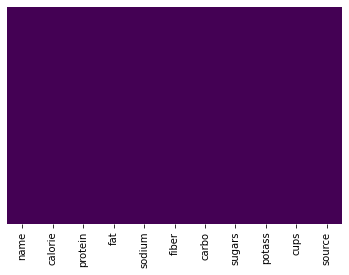

In [22]:
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [23]:
#set index to the name of the cereal
result.index = result.name

In [24]:
df_num = result[["calorie","protein","fat","sodium","fiber","carbo","sugars","potass"]]

In [28]:
#drop all instances outside of 3 sd from mean
df_num =df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]

NameError: name 'stats' is not defined

In [26]:
def  rescaleFeatures(df_in):
    # This function rescale all the columns in dataframe df_in to be
    # between 0 and 1. It returns the scaled dataframe as well as the
    # lists of minimum and the maximum (so we can rescale back)

    df_out = df_in # first, we make a copy of the original df
    m = df_out.min() # a list of minimums for all columns in df_in
    M = df_out.max() # a list of maximums for all columns in df_in
    for i in range(len(df_out.columns)):
        df_out.iloc[:,i] = (df_out.iloc[:,i] - m[i])/(M[i]-m[i])
    
    return df_num,m,M
df_num,m,M = rescaleFeatures(df_num)

/Users/monicakang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


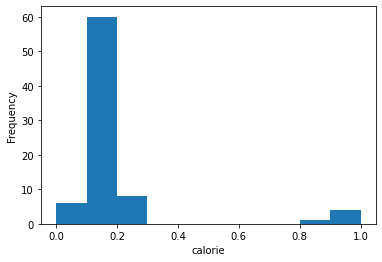

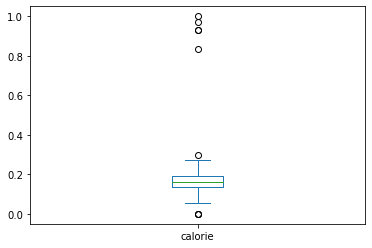

mean: 0.20408930765350788
median: 0.16260162601626016
min: 0.0
max: 1.0
stdev: 0.19788965507580297
______________________________________________________________________



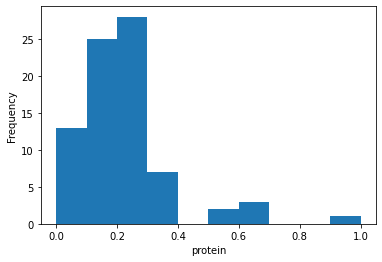

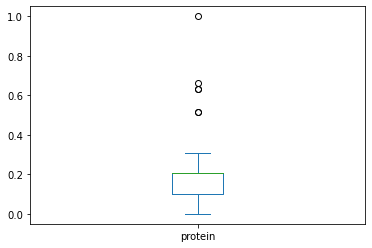

mean: 0.1833258244079916
median: 0.2059732226717554
min: 0.0
max: 1.0
stdev: 0.16953779898783508
______________________________________________________________________



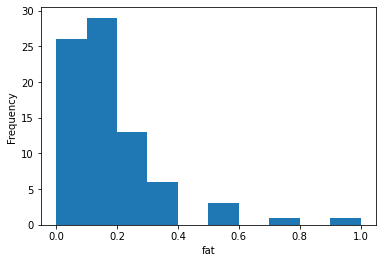

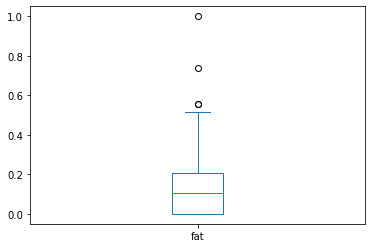

mean: 0.13893150537832138
median: 0.1033057818671051
min: 0.0
max: 1.0
stdev: 0.1750564454883678
______________________________________________________________________



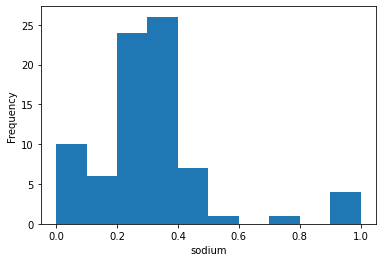

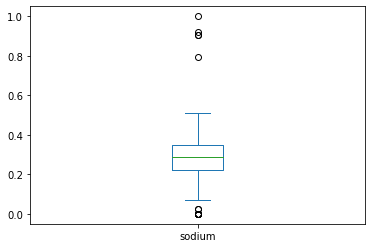

mean: 0.3029233060312732
median: 0.2858823529411765
min: 0.0
max: 1.0
stdev: 0.2013125421543391
______________________________________________________________________



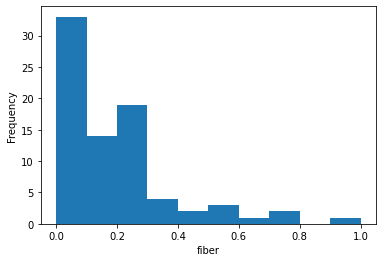

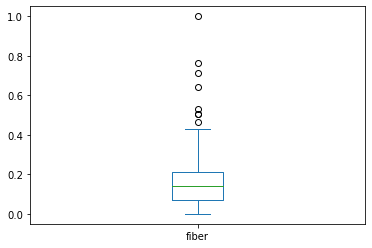

mean: 0.18156185083719495
median: 0.14285714285714285
min: 0.0
max: 1.0
stdev: 0.19511367679209463
______________________________________________________________________



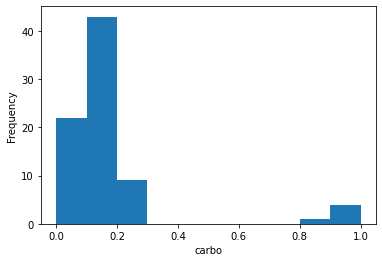

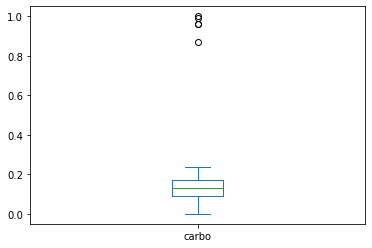

mean: 0.17936028462904335
median: 0.13075060532687652
min: 0.0
max: 1.0
stdev: 0.20944932531757834
______________________________________________________________________



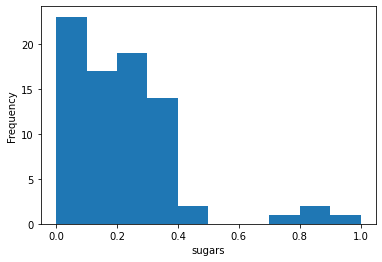

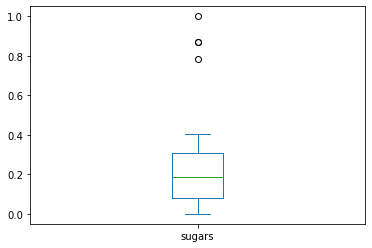

mean: 0.22725012637693667
median: 0.189
min: 0.0
max: 1.0
stdev: 0.19037464417814948
______________________________________________________________________



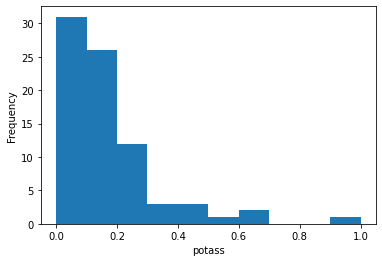

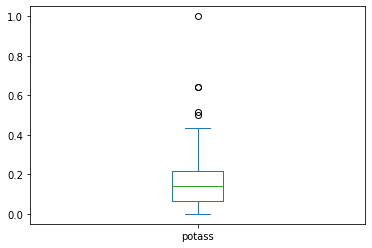

mean: 0.17886990300308964
median: 0.14130434782608695
min: 0.0
max: 1.0
stdev: 0.1632983253638842
______________________________________________________________________



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#subject = .select_dtypes(include='number')
for x in df_num:
    df_num[x].plot.hist()
    plt.xlabel(x)
    plt.show()
    df_num[x].plot.box()
    plt.show()
    print("mean:",df_num[x].mean())
    print("median:",df_num[x].median())
    print("min:",df_num[x].min())
    print("max:",df_num[x].max())
    print("stdev:",df_num[x].std())
    print("______________________________________________________________________")
    print("")

In [41]:
df3 = pd.read_csv('/Users/monicakang/Desktop/Cereal_Project/cereal_kaggle.csv', delimiter=',')
df3.dataframeName = 'cereal_kaggle.csv'
nutrition_facts = ["calories","protein","fat","sodium","fiber","carbo","sugars","potass"]
df3[nutrition_facts].corr()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass
calories,1.000000,0.019066,0.498610,0.300649,-0.293413,0.250681,0.562340,-0.066609
protein,0.019066,1.000000,0.208431,-0.054674,0.500330,-0.130864,-0.329142,0.549407
fat,0.498610,0.208431,1.000000,-0.005407,0.016719,-0.318043,0.270819,0.193279
sodium,0.300649,-0.054674,-0.005407,1.000000,-0.070675,0.355983,0.101451,-0.032603
fiber,-0.293413,0.500330,0.016719,-0.070675,1.000000,-0.356083,-0.141205,0.903374
carbo,0.250681,-0.130864,-0.318043,0.355983,-0.356083,1.000000,-0.331665,-0.349685
sugars,0.562340,-0.329142,0.270819,0.101451,-0.141205,-0.331665,1.000000,0.021696
potass,-0.066609,0.549407,0.193279,-0.032603,0.903374,-0.349685,0.021696,1.000000


|       | Calorie | Protein | Fat | Sodium | Fiber | Carbo | Sugars | Potass |Cups|
|-------|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-----:|
|Mean|125.3089545241444|2.780093761994925|1.3448570144606822|190.72948898265355|2.54186591172073|18.717740287369427|8.416671347293953|114.19221753398968| 0.8170886075949368 | 
|Median|110.0|3.0|1.0|180.0|2.0|15.0|7.0|90.0| 0.75 |
|Min|50.0|1.0|0.0|0.0|0.0|5.0|0.0| -1.0| 0.25 |
|Max|419.0|10.710000038146973|9.680000305175781|629.6296296296297|14.0|81.48148148148148|37.03703703703704|643.0| 1.5 |
|Stdev|73.02128272297129|1.6462120346392324|1.6945464457503874|126.75234135643575|2.7315914750893255|16.018994695585157|7.05091274733887|105.16412153434145|0.22870960144171065|

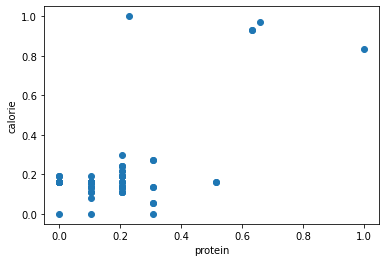

In [43]:
x = df_num['protein']
y = df_num['calorie']
plt.scatter(x, y)
plt.xlabel("protein")
plt.ylabel("calorie")
plt.show()